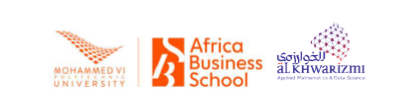

<h1 style='text-align: center;'>Lab</h1> 

<h3 style='text-align: center;'> Master of Science in Quantitative and Financial Modelling </h3>


#### Surpervisor: Fahd Kelloubi
#### Author : Oumaima Chqaf
****

## I- Introduction and Overview :

This notebook aims to showcase the process of web scraping and data visualization using **Dash** and **Plotly**. The specific task is to scrape the data for the "**Top 50 Crime Movies and TV Shows**" from *IMDb* and create interactive visualizations based on the scraped data.

The assignment requirements are as follows:

- Create a web app using **Dash** and **Plotly**.
- Scrape the content of your choice: Scrape the data for the **top 150 crime movies and TV shows** from *IMDb* to obtain relevant information such as title, year, rating, etc.
- Visualize the results through multiple charts: Utilize **Plotly** to create various charts and visualizations based on the scraped data.
- Try to create your own charts based on the chosen content: Extend the visualization beyond the provided examples by exploring different chart types and additional insights from the scraped data.

The goal is to demonstrate how to retrieve data from a website, preprocess it, and create engaging visual representations using **Dash** and **Plotly**.

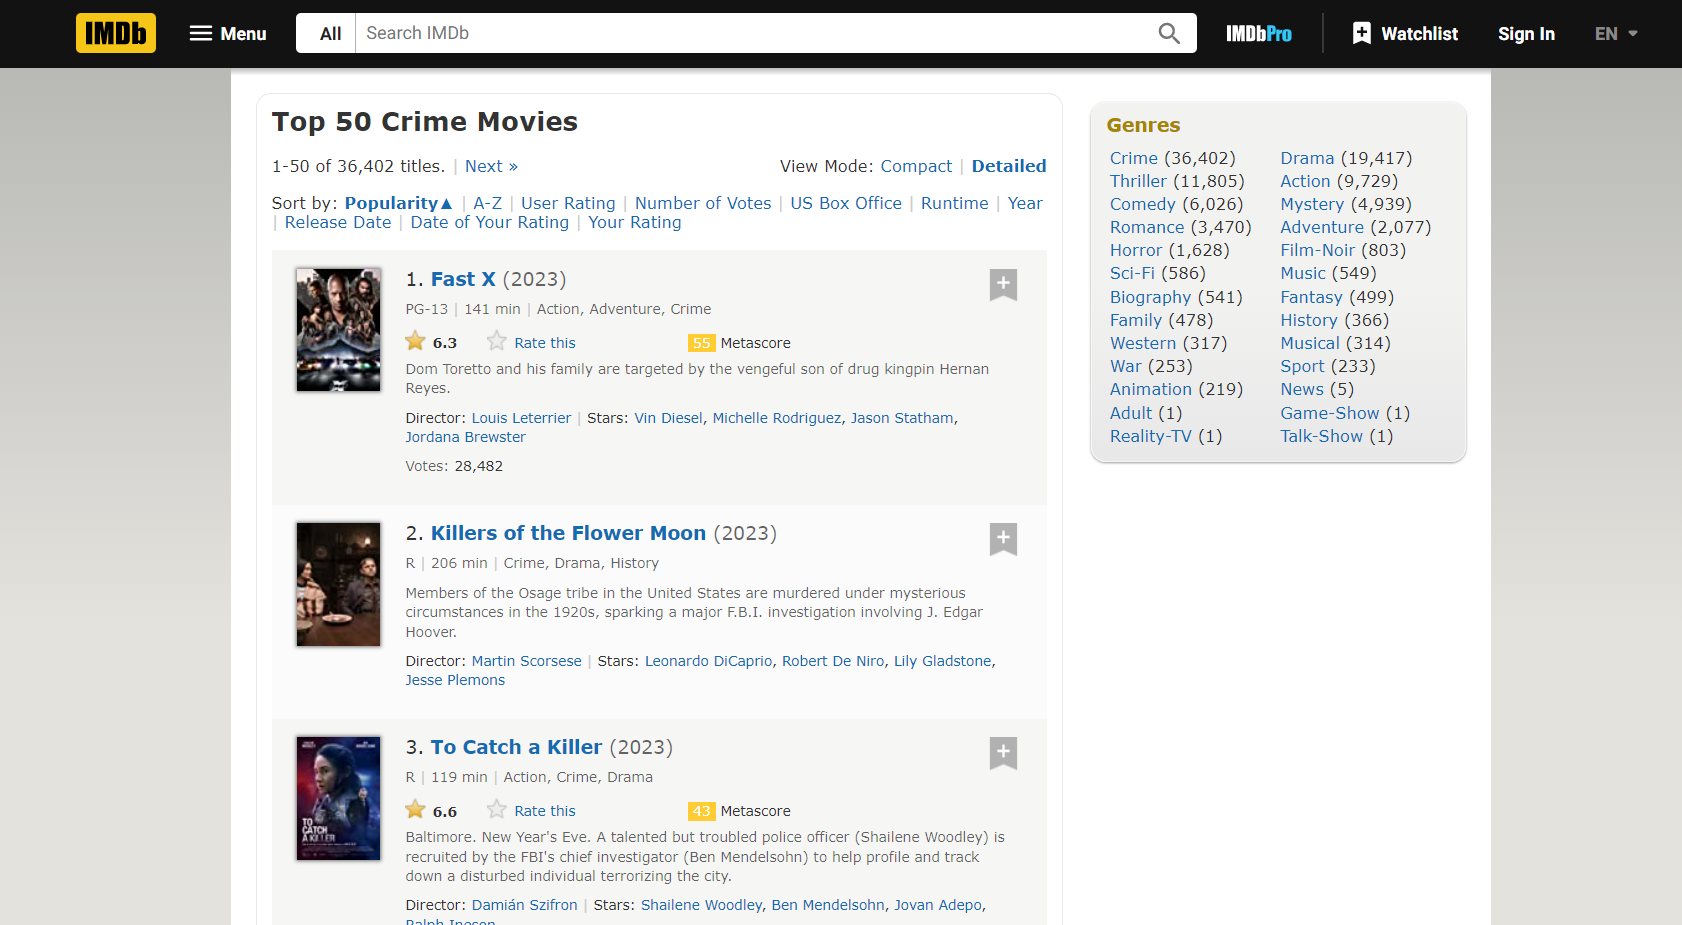

## II- Importing Required Libraries:

We import the requried packages.

In [11]:
import bs4
import requests
import time
import random as ran
import sys
import pandas as pd
import numpy as np

# import plotly.offline as pyo
import plotly.graph_objs as go

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

##  III- Web Scraping:

We start by searching the **Top 150 Crime Movies** (https://www.imdb.com/search/title/?genres=Crime&explore=genres&title_type=feature&ref_=ft_movie_5) and scrape results from the page.

The code bellow extracts all data on the first page.

In [2]:
url = 'https://www.imdb.com/search/title/?genres=Crime&explore=genres&title_type=feature&ref_=ft_movie_5'

source = requests.get(url).text
soup = bs4.BeautifulSoup(source,'html.parser')

Now, let's write a code to extract movie information.

In [3]:
movie_blocks = soup.findAll('div',{'class':'lister-item-content'})

Before extracting information across all movies, try first to examine one of the extracted block to identify the elements that we need to scrape.

Below  the elements from the first movie block are extracted

In [4]:
mname = movie_blocks[0].find('a').get_text() # Name of the movie

m_reyear = int(movie_blocks[0].find('span',{'class': 'lister-item-year'}).contents[0][1:-1]) # Release year

m_rating = float(movie_blocks[0].find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value')) #rating

m_mscore = float(movie_blocks[0].find('span',{'class':'metascore'}).contents[0].strip()) #meta score

m_votes = int(movie_blocks[0].find('span',{'name':'nv'}).get('data-value')) # votes

print("Movie Name: " + mname,
      "\nRelease Year: " + str(m_reyear),
      "\nIMDb Rating: " + str(m_rating),
      "\nMeta score: " + str(m_mscore),
      "\nVotes: " + '{:,}'.format(m_votes)

)

Movie Name: Fast X 
Release Year: 2023 
IMDb Rating: 6.3 
Meta score: 55.0 
Votes: 28,650


We will be using this feature during the scrape to iterate through all pages.

Now since scraping the data is an iterative process, we define separate functions for each purpose.

First we are going to define a function which will extract the targeted elements from a 'movie block list'.

In [5]:
def scrape_mblock(movie_block):
    
    movieb_data ={}
  
    try:
        movieb_data['name'] = movie_block.find('a').get_text() # Name of the movie
    except:
        movieb_data['name'] = None

    try:    
        movieb_data['year'] = str(movie_block.find('span',{'class': 'lister-item-year'}).contents[0][1:-1]) # Release year
    except:
        movieb_data['year'] = None

    try:
        movieb_data['rating'] = float(movie_block.find('div',{'class':'inline-block ratings-imdb-rating'}).get('data-value')) #rating
    except:
        movieb_data['rating'] = None

    try:
        movieb_data['m_score'] = float(movie_block.find('span',{'class':'metascore'}).contents[0].strip()) #meta score
    except:
        movieb_data['m_score'] = None

    try:
        movieb_data['votes'] = int(movie_block.find('span',{'name':'nv'}).get('data-value')) # votes
    except:
        movieb_data['votes'] = None

    return movieb_data
    

Then we create the below function to scrape all movie blocks within a single search result page

In [6]:
def scrape_m_page(movie_blocks):
    
    page_movie_data = []
    num_blocks = len(movie_blocks)
    
    for block in range(num_blocks):
        page_movie_data.append(scrape_mblock(movie_blocks[block]))
    
    return page_movie_data

Now we built functions to extract all movie data from a single page.

Next function will be created to iterate the above made function through all pages of the search result untill we scrape data for the targeted number of movies

In [7]:
def scrape_this(link,t_count):
    
    #from IPython.core.debugger import set_trace

    base_url = link
    target = t_count
    
    current_mcount_start = 0
    current_mcount_end = 0
    remaining_mcount = target - current_mcount_end 
    
    new_page_number = 1
    
    movie_data = []
    
    
    while remaining_mcount > 0:

        url = base_url + str(new_page_number)
        
        #set_trace()
        
        source = requests.get(url).text
        soup = bs4.BeautifulSoup(source,'html.parser')
        
        movie_blocks = soup.findAll('div',{'class':'lister-item-content'})
        
        movie_data.extend(scrape_m_page(movie_blocks))   
        
        current_mcount_start = int(soup.find("div", {"class":"nav"}).find("div", {"class": "desc"}).contents[1].get_text().split("-")[0])

        current_mcount_end = int(soup.find("div", {"class":"nav"}).find("div", {"class": "desc"}).contents[1].get_text().split("-")[1].split(" ")[0])

        remaining_mcount = target - current_mcount_end
        
        print('\r' + "currently scraping movies from: " + str(current_mcount_start) + " - "+str(current_mcount_end), "| remaining count: " + str(remaining_mcount), flush=True, end ="")
        
        new_page_number = current_mcount_end + 1
        
        time.sleep(ran.randint(0, 10))
    
    return movie_data
    
    

Finally, we put together all functions created above to scrape the top 150 movies on the list.

In [8]:
#We take the first 50 movies
base_scraping_link = "https://www.imdb.com/search/title/?genres=Crime&explore=genres&title_type=feature&ref_=ft_movie_5"

top_movies = 50 #input("How many movies do you want to scrape?")
films = []

films = scrape_this(base_scraping_link,int(top_movies))

df = pd.DataFrame(films)

df



currently scraping movies from: 1 - 50 | remaining count: 0

,name,year,rating,m_score,votes
0,Fast X,2023,6.3,55.0,28650.0
1,Killers of the Flower Moon,2023,NaN,NaN,NaN
2,Misanthrope,2023,6.6,43.0,8368.0
3,John Wick: Chapter 4,2023,8.1,78.0,173452.0
4,F9,2021,5.2,58.0,145423.0
5,Heat,1995,8.3,76.0,675520.0
6,AKA,2023,6.6,NaN,8453.0
7,The Fast and the Furious,2001,6.8,58.0,398794.0
8,The Godfather,1972,9.2,100.0,1908418.0
9,Shazam! Fury of the Gods,2023,6.0,47.0,74941.0


## IV- Data Visualization:

In [12]:

scatter_plot = px.scatter(df, x='votes', y='rating', color='name', title='Movie Ratings Scatter Plot')
bar_plot = px.bar(df, x='name', y='rating', title='Movie Ratings Bar Plot')
pie_chart = px.pie(df, values='rating', names='name', title='Movie Ratings Pie Chart')

app.layout = html.Div(
    children=[
        html.H1('Movie Ratings Visualization'),
        html.Div([
            html.Label('Select Plot Type:'),
            dcc.Dropdown(
                id='plot-type',
                options=[
                    {'label': 'Scatter Plot', 'value': 'scatter'},
                    {'label': 'Bar Plot', 'value': 'bar'},
                    {'label': 'Pie Chart', 'value': 'pie'}
                ],
                value='bar',
                clearable=False
            ),
            html.Label('Select Number of Movies:'),
            dcc.Dropdown(
                id='num-movies',
                options=[
                    {'label': 'Top 10 Movies', 'value': 10},
                    {'label': 'Top 20 Movies', 'value': 20},
                    {'label': 'Top 30 Movies', 'value': 30},
                    {'label': 'Top 40 Movies', 'value': 40},
                    {'label': 'Top 50 Movies', 'value': 50}
                ],
                value=10,
                clearable=False
            ),
            html.Label('Select Metric:'),
            dcc.Dropdown(
                id='metric',
                options=[
                    {'label': 'Metascore (m_score)', 'value': 'm_score'},
                    {'label': 'Votes', 'value': 'votes'},
                    {'label': 'Rating', 'value': 'rating'}
                ],
                value='rating',
                clearable=False
            ),
            html.Label('Display Pandas DataFrame:'),
            dcc.Dropdown(
                id='show-dataframe',
                options=[
                    {'label': 'Yes', 'value': 'yes'},
                    {'label': 'No', 'value': 'no'}
                ],
                value='yes',
                clearable=False
            ),
            dcc.Graph(id='plot'),
            html.Div(id='dataframe-container')
        ])
    ]
)

@app.callback(
    [dash.dependencies.Output('plot', 'figure'),
     dash.dependencies.Output('dataframe-container', 'children')],
    [dash.dependencies.Input('plot-type', 'value'),
     dash.dependencies.Input('num-movies', 'value'),
     dash.dependencies.Input('metric', 'value'),
     dash.dependencies.Input('show-dataframe', 'value')]
)
def update_plot(plot_type, num_movies, metric, show_dataframe):
    filtered_df = df.head(num_movies)
    if plot_type == 'scatter':
        plot = px.scatter(filtered_df, x=metric, y='name', color='name', title=f'Movie Ratings Scatter Plot (Top {num_movies} Movies)')
    elif plot_type == 'bar':
        plot = px.bar(filtered_df, x='name', y=metric, color='name', title=f'Movie Ratings Bar Plot (Top {num_movies} Movies)')
    else:
        plot = px.pie(filtered_df, values=metric, names='name', color='name', title=f'Movie Ratings Pie Chart (Top {num_movies} Movies)')
    if show_dataframe == 'yes':
        dataframe = html.Table(
            # Create table header
            [html.Tr([html.Th(col) for col in filtered_df.columns])] +

            # Create table rows
            [html.Tr([html.Td(filtered_df.iloc[i][col]) for col in filtered_df.columns]) for i in range(len(filtered_df))]
                              )
    else:
        dataframe = ''

    return plot, dataframe


if __name__ == '__main__':
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


SystemExit: 1

C:\Users\Oum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

